In [1]:
from esmvalcore.dataset import Dataset

In [2]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}
model_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
# "ERA-Interim": 
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

In [3]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

In [4]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import axis_statistics, meridional_statistics
from esmvalcore.preprocessor import mask_landsea
import iris

import numpy as np

import matplotlib.pyplot as plt
import iris.quickplot as qplt
from scipy.stats import skew


In [36]:
def prepoc(cube):
    nino34_latext_region = {"start_longitude": 120., "end_longitude": 280., "start_latitude": -5., "end_latitude": 5.}
    cube = convert_units(cube, units="degC")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')
    cube = meridional_statistics(cube, 'mean')
    return cube

def prepoc3(cube):
    nino34_latext_region = {"start_longitude": 120., "end_longitude": 280., "start_latitude": -15., "end_latitude": 15.}
    cube = convert_units(cube, units="degC")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')
    skew_array = skew(cube.data, axis=0) ##2d? create cube
    new_cube = cube.collapsed('time', iris.analysis.MAX)
    new_cube.data = skew_array
    return new_cube
    
def sst_ske(cube): #calc skew outside function
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = convert_units(cube, units="degC")
    # cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')
    cube = area_statistics(cube,operator='mean')

    return cube

def compute(obs, mod):
    return abs((mod-obs)/obs)*100

In [6]:
model_datasets_prep2 = {name: prepoc(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: prepoc(dataset) for name, dataset in obs_datasets.items()}


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(


In [7]:
model_datasets_prep = {name: sst_ske(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep = {name: sst_ske(dataset) for name, dataset in obs_datasets.items()}


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along first dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along first dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2140: IrisVagueMetadataWarning: Collapsin

Text(0.75, 0.8, '* observation')

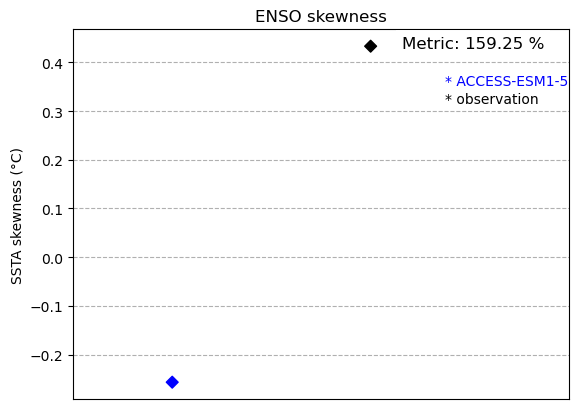

In [8]:
model_skew = skew(model_datasets_prep["ACCESS-ESM1-5"].data, axis=0)
obs_skew = skew(obs_datasets_prep["HadISST"].data, axis=0)

metric = [model_skew,obs_skew]


plt.scatter(range(len(metric)), metric, c=['blue','black'], marker='D')

plt.xlim(-0.5,2)#range(-1,3,1)) #['model','obs']
plt.xticks([])

plt.ylabel('SSTA skewness (°C)')
plt.grid(linestyle='--', axis='y')
plt.title('ENSO skewness')

metricval = compute(metric[1],metric[0])

plt.text(0.95, 0.95, f'Metric: {metricval:.2f} %', fontsize=12, ha='right', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(0.75,0.85, '* ACCESS-ESM1-5', color='blue',transform=plt.gca().transAxes)
plt.text(0.75,0.8, '* observation', color='black',transform=plt.gca().transAxes)
plt.show()

## diagnostic level 2

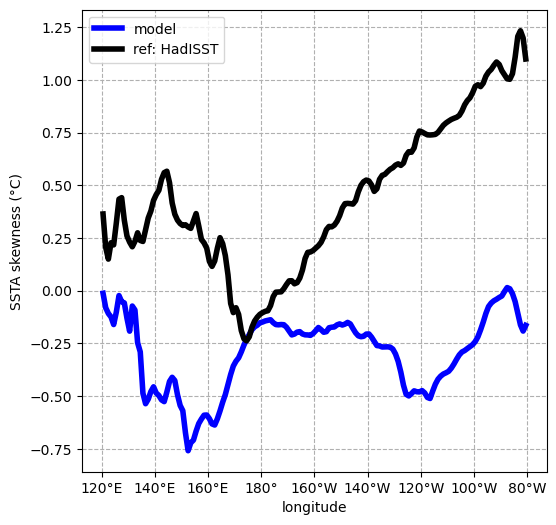

In [9]:
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

# Calculate the skew
model_skew_dev = skew(model_datasets_prep2["ACCESS-ESM1-5"].data, axis=0)
obs_skew_dev = skew(obs_datasets_prep2["HadISST"].data, axis=0)

# Create the plot
plt.figure(figsize=(6, 6))
plt.plot(model_datasets_prep2["ACCESS-ESM1-5"].coord('longitude').points, model_skew_dev, c='b', linewidth=4, label='model')
plt.plot(obs_datasets_prep2["HadISST"].coord('longitude').points, obs_skew_dev, c='k', linewidth=4, label='ref: HadISST')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))
# Set the x and y axis labels
plt.xlabel('longitude')
plt.ylabel('SSTA skewness (°C)')
plt.grid(linestyle='--'); plt.legend()


## dive down level 3

In [37]:
# 2d?
model_datasets_prep3 = {name: prepoc3(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep3 = {name: prepoc3(dataset) for name, dataset in obs_datasets.items()}

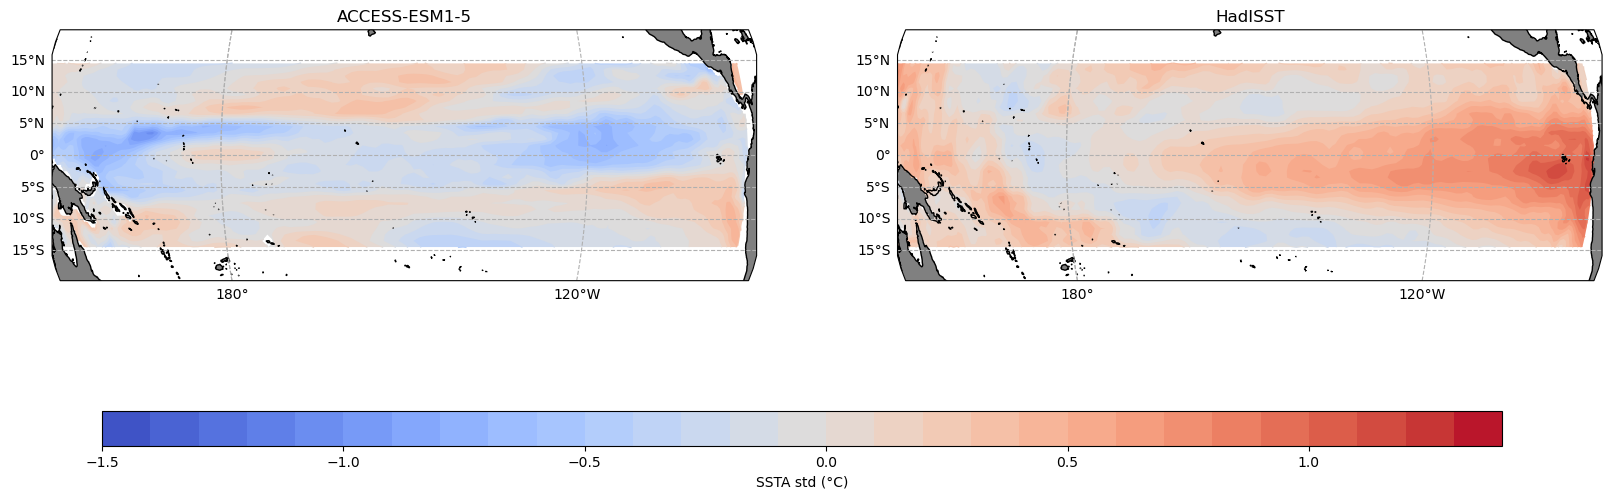

In [46]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
proj = ccrs.Orthographic(central_longitude=210.0)
i = 121
process = {**model_datasets_prep3,"HadISST":obs_datasets_prep3["HadISST"]}

for label, skew_cube in process.items():
    
    ax1 = plt.subplot(i, projection=proj)
    ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
    ax1.coastlines()
    cf1 = iplt.contourf(skew_cube, levels=np.arange(-1.5,1.5,0.1), cmap='coolwarm')

    ax1.set_extent([130, 290, -20, 20], crs=ccrs.PlateCarree())
    ax1.set_title(label)

    # Add gridlines for latitude and longitude
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False

    i+=1


# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-1.5,1.5,0.5))
cbar.set_label('SSTA std (°C)')